In [1]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo  # noqa: F401
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

from utils import predict_xr

In [2]:
%reload_ext autoreload
%autoreload 2

## Find and load S2 data

Load data and set up your array to use for prediction

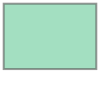

In [3]:
fiji_bbox = [177.2, -18.4, 178.9, -17.2]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry

In [4]:
collection = "dep_s2_geomad"

client = Client.open("https://stac.staging.digitalearthpacific.org")

items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023"
).items())

print(f"Found {len(items)} items")

Found 6 items


In [5]:
# S2 bands https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y": 2000, "time": np.atleast_1d(1),},
)

# Trying to fix issue with time dimension
# coords={ 'time':np.atleast_1d(time_),

data = data.squeeze("time")

data

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    B8A          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B11          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [6]:
# Add more indices here...

# Incorporate NDVI (Normalised Difference Vegetation Index) = (NIR-red)/(NIR+red)
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# Incorporate MNDWI (Mean Normalised Difference Water Index) = (Green – SWIR) / (Green + SWIR)
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# Incorporate EVI (Enhanced Vegetation Index) = 2.5NIR−RED(NIR+6RED−7.5BLUE)+1
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# Incorporate SAVI (Standard Vegetation Index) = (800nm−670nm) / (800nm+670nm+L(1+L)) # where L = 0.5
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# Incorporate BSI (Bare Soil Index) = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2)) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# Incorporate NDMI (Normalised Difference Moisture Index) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndmi/
data["ndmi"] = ((data["B08"]) - (data["B11"])) / ((data["B08"]) + (data["B11"]))

# Incorporate NDBI (Normalised Difference Built-up Index) (B06 - B05) / (B06 + B05); # - built up ratio of vegetation to paved surface - let BU = (ndvi - ndbi) - https://custom-scripts.sentinel-hub.com/custom-scripts/landsat-8/built_up_index/
data["ndbi"] = ((data["B06"]) - (data["B05"])) / ((data["B06"]) + (data["B05"]))


data

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/20)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    mndwi        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    evi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    savi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bsi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndmi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [7]:
# Add in the DEM here - https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30

# Get MPC dependencies

from planetary_computer import sign_url
import os

# Get the URL for STAC API on MSPC
catalogue_dem = "https://planetarycomputer.microsoft.com/api/stac/v1/"

collection_dem = "cop-dem-glo-30"

client_dem = Client.open(catalogue_dem)

# Search for datasets

fiji_bbox = [177.2, -18.4, 178.9, -17.2]

# datetime not necessary for DEM? 
# datetime = "2023"

# Get a pystac client for the MSPC
items_dem = list(client_dem.search(collections=[collection_dem], bbox=fiji_bbox).items())
print(len(items_dem))

4


In [8]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [9]:
# Load dem data - 

data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_dem = data_dem.where(data_dem != -32768)

data_dem = data_dem.squeeze("time").rename({"data":"elevation"})

data_dem

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2021-04-22
Data variables:
    elevation    (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>

In [10]:
# Merge DEM with S2 data
data_s2_dem = data.update(data_dem)
data_s2_dem

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2021-04-22
Data variables: (12/21)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    evi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    savi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bsi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndmi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    elevation    (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>

### ==Check that this has worked with Alex==

#### <code style="background:yellow;color:black">Check that DEM data has been correctly downloaded and integrated.</code> 

Table 1. Sentinel 2 bands and respective wavelengths
<div><img src="Spectral_Indices.JPG" width="600"/>

## Find and load S1 data

Load data and set up your array to use for prediction

In [11]:
# Get S-1 dependencies

from planetary_computer import sign_url
import os

In [12]:
# Get the URL for STAC API on MSPC
# STAC ITEM Geomedian S1 - https://stac-browser.staging.digitalearthpacific.org/?.language=en
catalog = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog)

In [13]:
# Search for datasets
fiji_bbox = [177.2, -18.4, 178.9, -17.2]
datetime = "2023"

items_s1 = list(client.search(collections=["dep_s1_mosaic"], bbox=fiji_bbox, datetime=datetime).items())
print(f"Found {len(items_s1)} items")

Found 6 items


In [14]:
data_s1 = load(items_s1, bbox=fiji_bbox, resolution=10, chunks={"x":4000, "y":4000},)
              # measurements=["std_vh", "std_vv", "mean_vh", "mean_vv", "mean_vv_vh"]).squeeze("time")
data_s1 = data_s1.where(data_s1 != -32768)
# data_s1 = data_s1.squeeze("time")
data_s1

# Plot dataset
# data.median_vv_vh.plot.imshow(size=10, robust=True)

<xarray.Dataset>
Dimensions:      (time: 1, y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    count        (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    std_vh       (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    std_vv       (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    median_vh    (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    median_vv    (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>

In [15]:
# Incorporate S1 band math combinations 
data_s1["mean_vv_vh"] = ((data_s1["mean_vv"]) / ((data_s1["mean_vh"])))

mean_s1 = data_s1.mean(dim="time")
mean_s1["mean_vv_vh"] = mean_s1.mean_vv/mean_s1.mean_vh
mean_s1

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
Data variables:
    count        (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    std_vh       (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    std_vv       (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    median_vh    (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    median_vv    (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [16]:
mean_s1

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
Data variables:
    count        (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    std_vh       (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    std_vv       (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    median_vh    (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    median_vv    (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [17]:
data_s1

<xarray.Dataset>
Dimensions:      (time: 1, y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    count        (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    std_vh       (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    std_vv       (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    median_vh    (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    median_vv    (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    mean_vv_vh   (time, y, x) float32 dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>

In [20]:
# Load the data
data_s1 = load(
    items_s1,
    bbox=fiji_bbox,
    resolution=10,
    bands=["mean_vv", "mean_vh"],
    chunks={"x":4000, "y":4000}
).squeeze("time")

# Mask the nodata values
data_s1 = data_s1.where(data_s1 != -32768)

# Calculate the vv / vh means
data_s1["mean_vv_vh"] = data_s1.mean_vv / data_s1.mean_vh

# Check what we have
data_s1

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables:
    mean_vv      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [21]:
# data_s1 = load(items_s1, bbox=fiji_bbox, resolution=10, chunks={"x":4000, "y":4000},
#               measurements=["std_vh", "std_vv", "mean_vh", "mean_vv", "mean_vv_vh"]).squeeze("time")
# data_s1 = data_s1.where(data_s1 != -32768)
# # data_s1 = data_s1.squeeze("time")
# data_s1


## Merge together all data into an array

Merge all collated data and set up your array to use for prediction

In [22]:
merged = data_s2_dem.update(data_s1).compute()
# merged = data_s2_dem.compute()

In [23]:
merged

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/24)
    B02          (y, x) float32 1.45e+03 1.459e+03 ... 1.421e+03 1.422e+03
    B03          (y, x) float32 1.277e+03 1.287e+03 ... 1.255e+03 1.248e+03
    B04          (y, x) float32 1.185e+03 1.201e+03 ... 1.192e+03 1.191e+03
    B05          (y, x) float32 1.189e+03 1.202e+03 ... 1.197e+03 1.201e+03
    B06          (y, x) float32 1.171e+03 1.185e+03 ... 1.176e+03 1.18e+03
    B07          (y, x) float32 1.178e+03 1.194e+03 ... 1.178e+03 1.182e+03
    ...           ...
    ndmi         (y, x) float32 -0.004325 -0.005567 ... -0.001698 -0.003828
    ndbi         (y, x) float32 -0.007627 -0.007122 ... -0.00885 -0.00882
    elevation    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_vv      (y, x) float32 0.01406 0.01459 0.01459 ... 0.02729 0.02857
    mean_vh      (y, x) float32 0.001504 0.001581 0.001581 ... 0.002298 0.00252
    mean_vv_vh   (y, x) float32 9.347 9.227 9.227 7.72 ... 11.58 11.88 11.34

## Train and predict

When you change your training data, you can re-train and predict here.

In [24]:
training_file = "training_data/draft_inputs/MRD_joined_14.geojson"

tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

In [26]:
from tqdm import tqdm

projected_training_data = tdata.to_crs("EPSG:3832")

# Remove the ID field
# projected_training_data.drop(columns=["id"], inplace=True)

training_array = []


def get_training_data(id_row):
    _, row = id_row
    cls_id = row["lulc_code"]
    # id = row["id"]
    geom = row["geometry"]

    # Get xarray values at the point
    x = merged.sel(x=geom.x, y=geom.y, method="nearest")
    one_point = [cls_id] + [float(v) for v in x.values()]
    return one_point


with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(
        tqdm(
            executor.map(get_training_data, projected_training_data.iterrows()),
            total=len(projected_training_data),
        )
    )

print(f"Fetched data for {len(training_array)} training points")

100%|██████████| 839/839 [00:00<00:00, 382169.97it/s]

Fetched data for 839 training points


In [30]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = classifier.fit(training_data, classes)

In [31]:
classifier.feature_importances_

array([0.0666546 , 0.02475041, 0.05241141, 0.03681336, 0.02919279,
       0.02931569, 0.06422215, 0.02893755, 0.06448685, 0.09242846,
       0.01941697, 0.01677136, 0.02010598, 0.05332716, 0.03660731,
       0.0521456 , 0.02635793, 0.0713082 , 0.05150581, 0.02907972,
       0.11686344, 0.00725341, 0.00359091, 0.00645292])

In [32]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3832")

ll = [-17.68786, 178.46045]
ur = [-17.60134, 178.55120]

ll_projected = transformer.transform(*ll)
ur_projected = transformer.transform(*ur)

predict_subset = merged.sel(
    x=slice(ll_projected[0], ur_projected[0]), y=slice(ur_projected[1], ll_projected[1])
)
# This one loads all the data from all Viti Levu
predict_subset = predict_subset.fillna(-9999)
predict_subset

<xarray.Dataset>
Dimensions:      (y: 1005, x: 1011)
Coordinates:
  * y            (y) float64 -1.978e+06 -1.978e+06 ... -1.988e+06 -1.988e+06
  * x            (x) float64 3.168e+06 3.168e+06 ... 3.178e+06 3.178e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/24)
    B02          (y, x) float32 1.352e+03 1.354e+03 ... 1.399e+03 1.408e+03
    B03          (y, x) float32 1.602e+03 1.618e+03 ... 1.764e+03 1.774e+03
    B04          (y, x) float32 1.301e+03 1.303e+03 ... 1.328e+03 1.337e+03
    B05          (y, x) float32 2.038e+03 2.04e+03 ... 2.274e+03 2.274e+03
    B06          (y, x) float32 4.249e+03 4.254e+03 ... 4.874e+03 4.88e+03
    B07          (y, x) float32 4.936e+03 4.944e+03 ... 5.69e+03 5.706e+03
    ...           ...
    ndmi         (y, x) float32 0.2468 0.2396 0.2567 ... 0.3064 0.2778 0.2642
    ndbi         (y, x) float32 0.3517 0.3518 0.3485 ... 0.3753 0.3637 0.3643
    elevation    (y, x) float32 228.1 228.1 228.1 222.4 ... 84.69 84.69 84.69
    mean_vv      (y, x) float32 0.3179 0.2956 0.3488 ... 0.2096 0.2079 0.2585
    mean_vh      (y, x) float32 0.06806 0.07837 0.0915 ... 0.04829 0.05976
    mean_vv_vh   (y, x) float32 4.671 3.772 3.812 4.129 ... 4.78 4.305 4.327

In [33]:
# This runs the actual prediction
predicted = predict_xr(model, predict_subset, proba=True)

# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

predicting...
   probabilities...


In [34]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 1011, y: 1005)
Coordinates:
  * x            (x) float64 3.168e+06 3.168e+06 ... 3.178e+06 3.178e+06
  * y            (y) float64 -1.978e+06 -1.978e+06 ... -1.988e+06 -1.988e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
    prob         (y, x) float32 89.24 80.05 90.23 91.0 ... 73.08 77.84 80.82
Attributes:
    grid_mapping:  spatial_ref

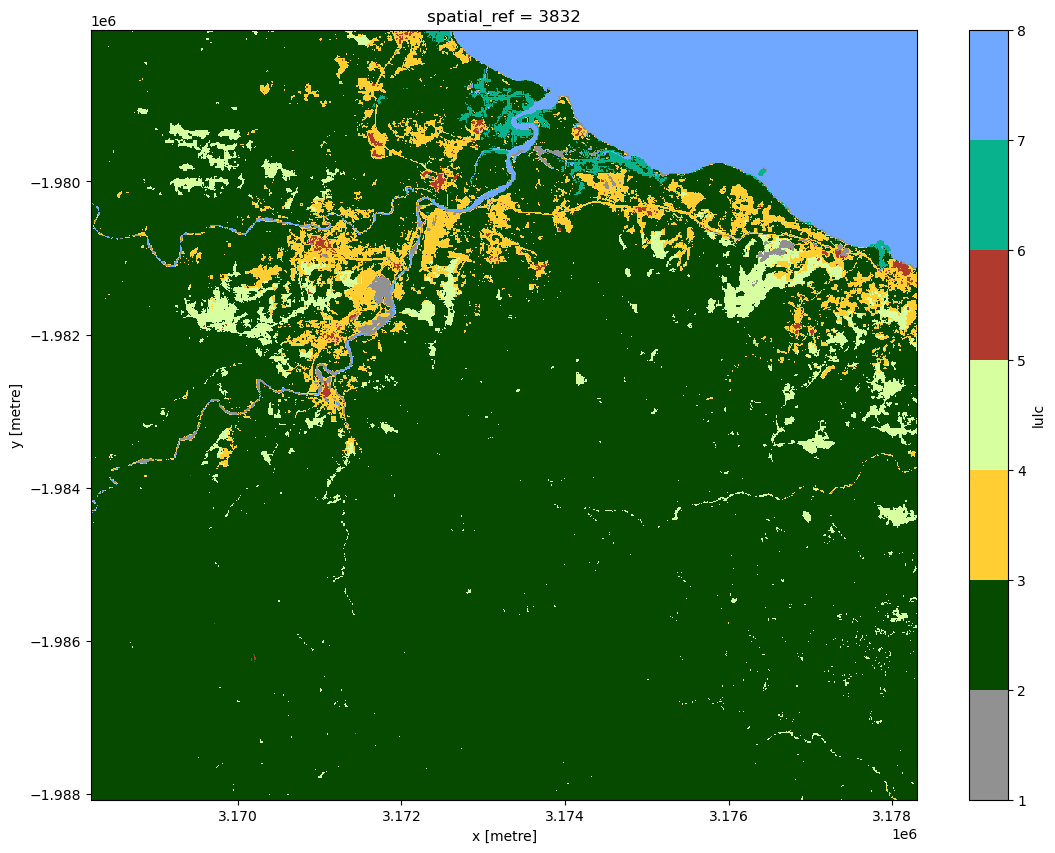

In [35]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#919191"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b03a2e"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [8]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

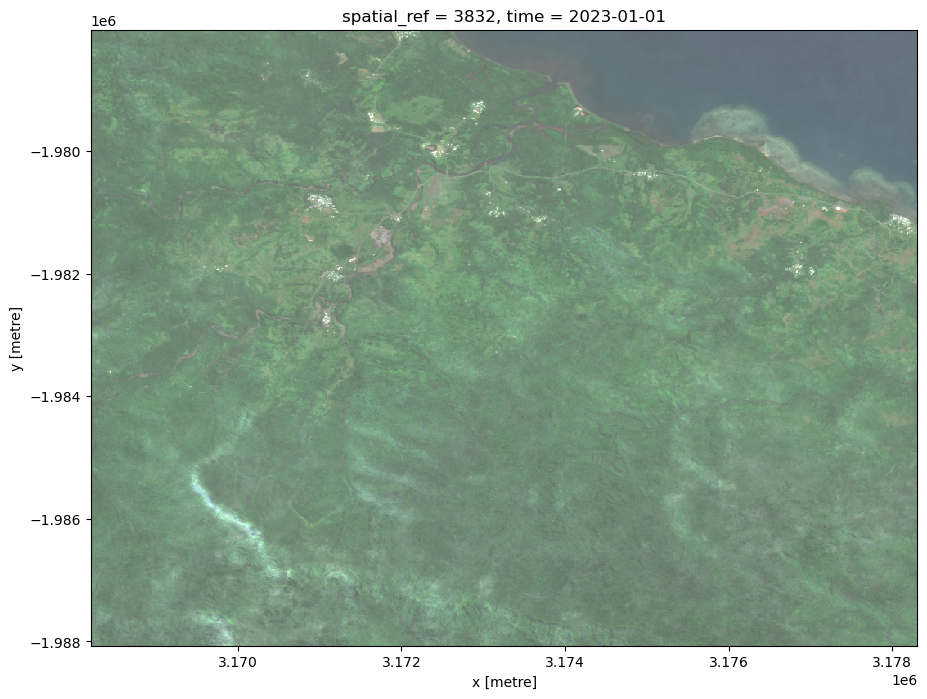

In [36]:
predict_subset[["B04", "B03", "B02"]].to_array().plot.imshow(size=8, vmin=0, vmax=3000)

In [ ]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("lulc_fiji_2023.tif", overwrite=True)

### Replicate for 2022

In [37]:
collection = "dep_s2_geomad"

client = Client.open("https://stac.staging.digitalearthpacific.org")

items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2022"
).items())

print(f"Found {len(items)} items")

Found 6 items


In [38]:
# S2 bands https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y": 2000, "time": np.atleast_1d(1),},
)

# Trying to fix issue with time dimension
# coords={ 'time':np.atleast_1d(time_),

data = data.squeeze("time")

data

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2022-01-01
Data variables: (12/13)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    B8A          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B11          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [39]:
# Incorporate NDVI (Normalised Difference Vegetation Index) = (NIR-red)/(NIR+red)
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# Incorporate MNDWI (Mean Normalised Difference Water Index) = (Green – SWIR) / (Green + SWIR)
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# Incorporate EVI (Enhanced Vegetation Index) = 2.5NIR−RED(NIR+6RED−7.5BLUE)+1
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# Incorporate SAVI (Standard Vegetation Index) = (800nm−670nm) / (800nm+670nm+L(1+L)) # where L = 0.5
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# Incorporate BSI (Bare Soil Index) = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2)) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# Incorporate NDMI (Normalised Difference Moisture Index) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndmi/
data["ndmi"] = ((data["B08"]) - (data["B11"])) / ((data["B08"]) + (data["B11"]))

# Incorporate NDBI (Normalised Difference Built-up Index) (B06 - B05) / (B06 + B05); # - built up ratio of vegetation to paved surface - let BU = (ndvi - ndbi) - https://custom-scripts.sentinel-hub.com/custom-scripts/landsat-8/built_up_index/
data["ndbi"] = ((data["B06"]) - (data["B05"])) / ((data["B06"]) + (data["B05"]))


data

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2022-01-01
Data variables: (12/20)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    mndwi        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    evi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    savi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bsi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndmi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [40]:
# Load dem data - 

data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_dem = data_dem.where(data_dem != -32768)

data_dem = data_dem.squeeze("time").rename({"data":"elevation"})

data_dem

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2021-04-22
Data variables:
    elevation    (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>

In [41]:
# Merge DEM with S2 data
data_s2_dem = data.update(data_dem)
data_s2_dem

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2021-04-22
Data variables: (12/21)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    evi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    savi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bsi          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndmi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    elevation    (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>

In [42]:
# Load the data
data_s1 = load(
    items_s1,
    bbox=fiji_bbox,
    resolution=10,
    bands=["mean_vv", "mean_vh"],
    chunks={"x":4000, "y":4000}
).squeeze("time")

# Mask the nodata values
data_s1 = data_s1.where(data_s1 != -32768)

# Calculate the vv / vh means
data_s1["mean_vv_vh"] = data_s1.mean_vv / data_s1.mean_vh

# Check what we have
data_s1

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables:
    mean_vv      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [ ]:
# merged = data_s2_dem.update(data_s1).compute()
merged = data_s2_dem.compute()

In [ ]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = classifier.fit(training_data, classes)

In [ ]:
classifier.feature_importances_